<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [119]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 


In [5]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences

#Toy data

In [154]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB',
       'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE',
       'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE',
       'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN',
       'METHOTREXATE', 'MITOMYCINE', 'MK-2206', 'MK-4541', 'MK-4827',
       'MK-5108', 'MK-8669', 'MRK-003', 'OXALIPLATIN', 'PACLITAXEL',
       'PD325901', 'SN-38', 'SORAFENIB', 'SUNITINIB', 'TEMOZOLOMIDE',
       'TOPOTECAN', 'VINBLASTINE', 'VINORELBINE', 'ZOLINZA',
       'CHEMBL17639', 'BUSULFAN', 'AZACYTIDINE', 'FLUDARABINE BASE',
       'TENIPOSIDE', 'NSC733504', 'EXEMESTANE', 'BLEOMYCIN',
       'ANTIBIOTIC AD 32', 'MITOXANTRONE', "5-FLUORO-2'-DEOXYURIDINE",
       'MITOTANE', 'METHOXSALEN', 'FULVESTRANT', 'CARMUSTINE',
       'ADM HYDROCHLORIDE', 'TAMOXIFEN CITRATE', 'CHEMBL277800',
       'ALLOPURINOL', 'THIOTEPA', 'MERCAPTOPURINE', 'ANTIBIOTIC AY 22989',
       'IFOSFAMIDE', 'ANASTROZOLE', 'VINCRISTINE SULFAT

#Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

In [210]:
list(drug_smiles.keys()).__len__()

124

In [189]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  """
  create feaature matrix
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumRadicalElectrons() for j in range(mol.GetNumAtoms())]]).T
  X = np.array(pd.concat([f1,f2],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = A_hat @ X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

In [213]:
feat_mat.__len__()

124

#Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    target_protein[i] = target_prot
  except Exception:
    pass


In [209]:
list(target_protein.keys()).__len__()

122

#Boolean

#Cell line

#Model

In [ ]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 10, 30)]     0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 30, 2)]      0                                            
__________________________________________________________________________________________________
graph_conv_19 (GraphConv)       (None, 10, 2)        60          input_15[0][0]                   
__________________________________________________________________________________________________
graph_conv_21 (GraphConv)       (None, 30, 2)        4           input_16[0][0]                   
____________________________________________________________________________________________

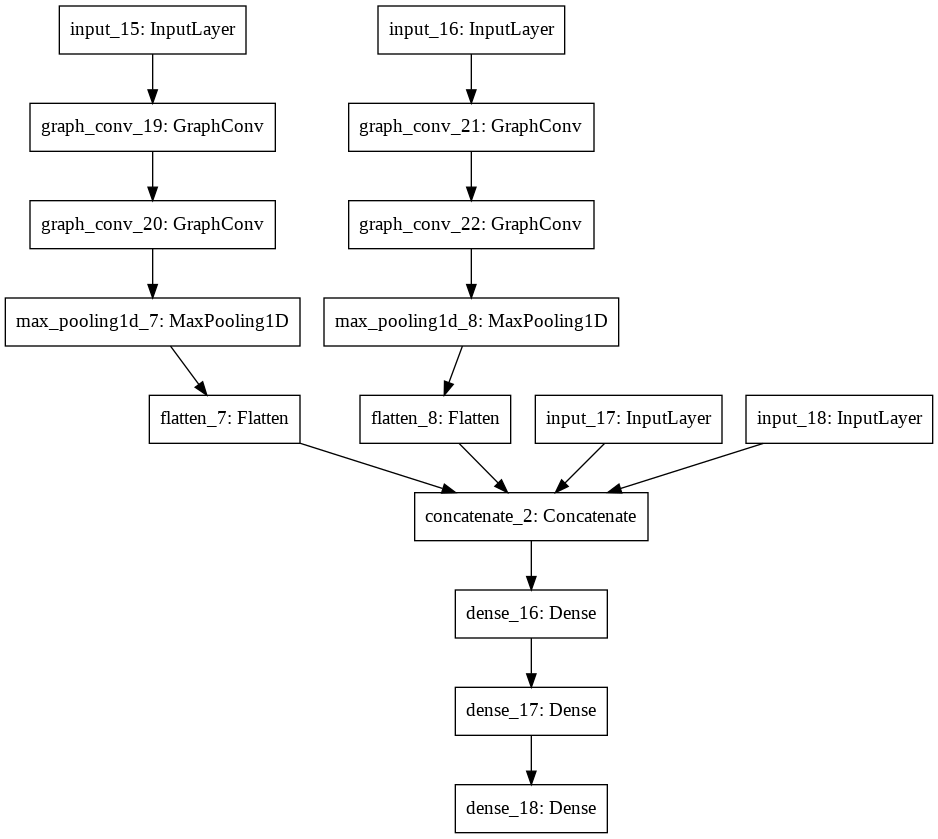

In [ ]:
# first input model

#boolean
visible1 = Input(shape=(10,30))
layer1 = GraphConv(2,activation='relu')(visible1)
layer2 = GraphConv(2,activation='relu')(layer1)
pool12 = tf.keras.layers.MaxPooling1D()(layer2)
flat1 = Flatten()(pool12)

#drug structure
visible2 = Input(shape=(30,2))
layer1 = GraphConv(2,activation='relu')(visible2)
layer2 = GraphConv(2,activation='relu')(layer1)
pool12 = tf.keras.layers.MaxPooling1D()(layer2)
flat2 = Flatten()(pool12)

#target protein
flat3 = Input(shape=(30,))

#cell line
flat4 = Input(shape=(30,))


# merge input models
merge = concatenate([flat1,flat2,flat3,flat4])
# interpretation model
hidden1 = Dense(2, activation='relu')(merge)
hidden2 = Dense(2, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=[visible1,visible2,flat3,flat4], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='multilayer_perceptron_graph.png')

##Simulate data

In [ ]:
def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1,
                              0.2,
                              0.3,
                              0.4,
                              0.5,
                              0.6,
                              0.7,
                              0.8,
                              0.9
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[df_x.shape[1]]
    ))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])

    model.compile(
        optimizer=keras.optimizers.SGD(lr, momentum=momentum),
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return model

In [ ]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='test_dir_03',
    project_name='b_tune_nn'
)

INFO:tensorflow:Reloading Oracle from existing project test_dir_03/b_tune_nn/oracle.json
